# 1. Introducción

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from utilidades.reducir_uso_memoria import reduce_mem_usage
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from xgboost import XGBRegressor


train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [2]:
pd.set_option('display.max_columns', 1000) #ver todas las columnas

In [3]:
pd.set_option('display.max_rows', 100) #como mucho ver 100 filas

# 2. Preprocesamiento de los Datos

### Se quita id, titulo, descripción, direccion e Idzona por no entenderlos como tan relevantes

In [4]:
dfinicial = train
dftest = test

dfinicial = dfinicial.drop( columns = ['id', 'titulo', 'descripcion', 'direccion', 'idzona'] )
dftest = dftest.drop( columns = ['id', 'titulo', 'descripcion', 'direccion', 'idzona'] )

### Se quita latitud y longitud por la cantidad de NaN, manejando la granularidad sólo a nivel Ciudad y Provincia

In [5]:
dfinicial = dfinicial.drop( columns = ['lat', 'lng'] )
dftest = dftest.drop( columns = ['lat', 'lng'] )

### Se rellenan con la moda Baños, Garages y Habitaciones

In [6]:
def completarAlgunosNan2(df):
    for column in ["banos", "garages", "habitaciones"]:
        df[column] = df.groupby(['provincia', 'tipodepropiedad'])[column].apply(lambda x: x.fillna(x.mode()))
        df[column] = df[column].fillna(df[column].mode()[0]) #Por si son todos NaN, y no hay moda
        
    return df
    

dfinicial = completarAlgunosNan2(dfinicial)
dftest = completarAlgunosNan2(dftest)

### Se rellena Antigüedad, Metros Cubiertos y Metros totales con la mediana para los casos de NaN, por tener estos atributos distribución log normal (aproximadamente)

In [7]:
def completarAlgunosNan(df):
    for column in ['antiguedad', 'metroscubiertos', 'metrostotales']:
        df[column] = df.groupby(['provincia', 'tipodepropiedad'])[column].apply(lambda x: x.fillna(x.median()))
        df[column] = df[column].fillna(df[column].median())

    return df

dfinicial = completarAlgunosNan(dfinicial)
dftest = completarAlgunosNan(dftest)
        

c:\users\dell\appdata\local\programs\python\python37\lib\site-packages\numpy\lib\nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


### Aplicar Onehot encoding para desprenderse de provincias, ciudades tipo de propiedad como tal

In [8]:
poblaciones = pd.read_csv("data/poblacion_de_cada_ciudad.csv")

d_poblaciones = poblaciones.set_index("ciudad")["poblacion"].to_dict()

dfinicial["ciudad"].fillna(dfinicial['ciudad'].mode()[0], inplace=True)

dfinicial["pob_ciu"] = dfinicial.apply(lambda x: d_poblaciones[x["ciudad"]], axis=1)

In [9]:
# Se hallan los casos posibles
provincias_posibles = train["provincia"].dropna().unique()
props_posibles = train["tipodepropiedad"].dropna().unique()
ciudades_posibles = train["ciudad"].dropna().unique()

# Se pasa tipodepropiedad y provincia a valores categóricos
dfinicial["tipodepropiedad"] = pd.Categorical(train["tipodepropiedad"], categories = props_posibles)
dfinicial["provincia"] = pd.Categorical(train["provincia"], categories = provincias_posibles)
dfinicial["ciudad"] = pd.Categorical(train["ciudad"], categories = ciudades_posibles)

dftest["tipodepropiedad"] = pd.Categorical(test["tipodepropiedad"], categories=props_posibles)
dftest["provincia"] = pd.Categorical(test["provincia"], categories=provincias_posibles)
dftest["ciudad"] = pd.Categorical(test["ciudad"], categories = ciudades_posibles)

# Rellenar nans de provincia, tipo de propiedad y ciudad, y usar onehot encoding
datos_categoricos = dfinicial[["tipodepropiedad", "provincia", "ciudad"]].copy()
datos_categoricos['tipodepropiedad'] = datos_categoricos.groupby(['provincia'])['tipodepropiedad'].apply(lambda x: x.fillna(x.mode()))
datos_categoricos["provincia"] = datos_categoricos["provincia"].fillna(datos_categoricos["provincia"].mode()[0])
datos_categoricos["ciudad"] = datos_categoricos.groupby(['provincia'])['ciudad'].apply(lambda x: x.fillna(x.mode()))
datos_categoricos = pd.get_dummies(datos_categoricos)
dfinicial = pd.concat([datos_categoricos, dfinicial], axis=1)

datos_categoricos = dftest[["tipodepropiedad", "provincia", "ciudad"]].copy()
datos_categoricos['tipodepropiedad'] = datos_categoricos.groupby(['provincia'])['tipodepropiedad'].apply(lambda x: x.fillna(x.mode()))
datos_categoricos["provincia"] = datos_categoricos["provincia"].fillna(datos_categoricos["provincia"].mode()[0])
datos_categoricos["ciudad"] = datos_categoricos.groupby(['provincia'])['ciudad'].apply(lambda x: x.fillna(x.mode()))
datos_categoricos = pd.get_dummies(datos_categoricos)
dftest = pd.concat([datos_categoricos, dftest], axis=1)

# Tirar tipodepropiedad y provincia
dfinicial = dfinicial.drop( columns = ['tipodepropiedad', 'provincia', 'ciudad'] )
dftest = dftest.drop( columns = ['tipodepropiedad', 'provincia', 'ciudad'] )

### Se pasa fecha a datetime y se agrega mes y año

In [10]:
dfinicial['fecha'] = dfinicial['fecha'].astype('datetime64')
dftest['fecha'] = dftest['fecha'].astype('datetime64')

dfinicial['dia'] = dfinicial['fecha'].dt.day
dfinicial['mes'] = dfinicial['fecha'].dt.month
dfinicial['anio'] = dfinicial['fecha'].dt.year
dfinicial = dfinicial.drop( columns = ['fecha'] )

dftest['dia'] = dftest['fecha'].dt.day
dftest['mes'] = dftest['fecha'].dt.month
dftest['anio'] = dftest['fecha'].dt.year
dftest = dftest.drop( columns = ['fecha'] )

### Adecuación de tipos de datos ahora que no hay NaN

In [11]:
 def parseoNan(df):
    df['gimnasio'] = df['gimnasio'].astype(np.uint8)
    df['usosmultiples'] = df['usosmultiples'].astype(np.uint8)
    df['piscina'] = df['piscina'].astype(np.uint8)
    df['escuelascercanas'] = df['escuelascercanas'].astype(np.uint8)
    df['centroscomercialescercanos'] = df['centroscomercialescercanos'].astype(np.uint8)
    
    df['garages'] = df['garages'].astype(np.uint8)
    df['antiguedad'] = df['antiguedad'].astype(np.uint8)
    df['banos'] = df['banos'].astype(np.uint8)
    df['habitaciones'] = df['habitaciones'].astype(np.uint8)
    
    df['metroscubiertos'] = df['metroscubiertos'].astype(np.uint16)
    df['metrostotales'] = df['metrostotales'].astype(np.uint16)
   
    df['dia'] = df['dia'].astype(np.uint8)
    df['mes'] = df['mes'].astype(np.uint8)
    df['anio'] = df['anio'].astype(np.uint16)
    
parseoNan(dfinicial)
parseoNan(dftest)

dfinicial['precio'] = dfinicial['precio'].astype(np.uint32)

In [12]:
dfinicial = reduce_mem_usage(dfinicial)
dftest = reduce_mem_usage(dftest)

In [19]:
X, y = dfinicial.drop(["precio"], axis=1),dfinicial["precio"]

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [22]:
reg = XGBRegressor(max_depth=15, min_child_weight=0.01, n_jobs=-1, objective ='reg:squarederror')

In [23]:
y_train = np.log(y_train)
reg.fit(X_train, y_train)
pred = reg.predict(X_test)
pred = np.exp(pred)

c:\users\dell\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [31]:
mean_absolute_error(y_test, pred)

ValueError: Found input variables with inconsistent numbers of samples: [79200, 330]

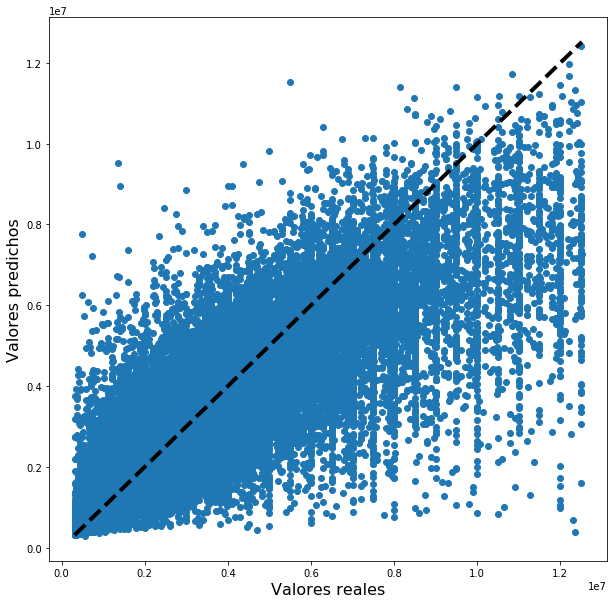

In [26]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(y_test, pred)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel("Valores reales", fontsize=16)
ax.set_ylabel("Valores predichos", fontsize=16);